In [14]:
import pandas as pd

from preprocess import clean_dataframe
# https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

raw_data = pd.read_csv('Murder_Data.zip', index_col=0, compression='zip')
cleaned_data = clean_dataframe(raw_data).sample(n=24000)

C:\Users\PedroAntonio\Anaconda3\envs\ACML\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
input_features = ['County', 'State', 'Area', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'VicCount', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide']
output_features = ['OffAge', 'OffSex', 'OffRace', 'OffEthnic', 'OffCount']

X = cleaned_data[input_features]
Y = cleaned_data[output_features]

X['VicAge'].replace(to_replace='Unknown', value = -1, inplace = True)
Y['OffAge'].replace(to_replace='Unknown', value = -1, inplace = True)

X = pd.get_dummies(X,columns=['County', 'State', 'Area', 'VicSex', 'VicRace', 'VicEthnic', 'Weapon', 'Subcircum', 'Circumstance', 'Homicide'])

x_train, x_rest, y_train, y_rest = train_test_split(X, Y, test_size=0.20, random_state=20)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.50, random_state=20)

C:\Users\PedroAntonio\Anaconda3\envs\ACML\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


0.88375


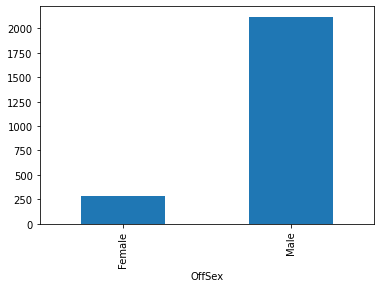

In [16]:
df=y_test.groupby(["OffSex"]).size()
df.plot(kind='bar')
print(len(y_test[y_test["OffSex"]=="Male"])/len(y_test))

no weighted penalty for the classes
done fitting
Accuracy on female class: 0.014336917562724014
Accuracy on male class: 0.9929278642149929


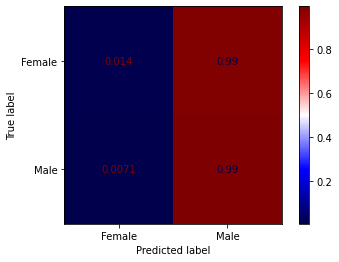

In [17]:
#clf = svm.LinearSVC(class_weight={'Female':10, 'Male': 1},dual=False)
print("no weighted penalty for the classes")
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffSex"])
print("done fitting")
print("Accuracy on female class: "+str(clf.score(x_test[y_test["OffSex"]=="Female"],y_test["OffSex"][y_test["OffSex"]=="Female"])))
print("Accuracy on male class: "+str(clf.score(x_test[y_test["OffSex"]=="Male"],y_test["OffSex"][y_test["OffSex"]=="Male"])))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffSex"],normalize='true',cmap="seismic")

In [18]:
import random
def genetic_weight_search(n_pop,n_iter,tree,classes,x_train,y_train,x_val,y_val):
    pop = init_population(n_pop,classes)
    for i in range(n_iter):
        fitness = eval_pop(pop,tree,x_train,y_train,x_val,y_val)
        sorted_pop = sorted(zip(fitness,pop), key = lambda l: l[0],reverse=True)
        print(sorted_pop[0])
        parents = select_parents(sorted_pop)
        #no crossover
        children = generate_new_pop(parents,n_new=10)
        pop = parents+children+init_population(5,classes)
    print("best found:"+str(pop[0]))
    return pop[0]


def init_population(n_pop,classes):
    pop = []
    for i in range(n_pop):
        individual = {}
        for cls in classes:
            individual[cls]=random.uniform(1,10)
        pop.append(individual)
    return pop

def eval_pop(pop,tree,x_train,y_train,x_val,y_val):
    fitness = []
    for individual in pop:
        clf = tree(class_weight=individual,dual=False)
        clf.fit(x_train, y_train)
        mean = 0
        multi = 1
        for cls in individual.keys():
            score=clf.score(x_val[y_val==cls],y_val[y_val==cls])
            mean+=score
            multi*=score
        #todo: the current fitness value should be retought, for exaple: should 0.7/0.7 be considerd better as 0.5/1.0 or not?
        fitness.append(multi)
    return fitness

def select_parents(sorted_pop):
    res = [[ i for i, j in sorted_pop ],[ j for i, j in sorted_pop ]]
    pop = res[1]
    #return best 5 and 5 random as parents of the population
    parents = pop[:5]
    parents += random.sample(pop[5:], 5)
    return parents

def generate_new_pop(parents,n_new):
    new_pop = []
    for i in range(n_new):
        parent = random.sample(parents,1)[0]
        parent = parent.copy()
        child = {}
        for cls in parent.keys():
            child[cls]=parent[cls]+random.uniform(-0.4,0.4)
        new_pop.append(child)
    return new_pop

(0.26228242889384473, {'Female': 8.79680456155099, 'Male': 2.1712604939261233})
(0.26228242889384473, {'Female': 8.79680456155099, 'Male': 2.1712604939261233})
(0.2853320742839156, {'Female': 8.477483202167624, 'Male': 1.9543510600674803})
(0.3124033110320857, {'Female': 8.46452318112537, 'Male': 1.5656463829274467})
(0.3124033110320857, {'Female': 8.46452318112537, 'Male': 1.5656463829274467})
(0.32341329636549937, {'Female': 8.518118318721637, 'Male': 1.5115406677471466})
(0.33647760834187207, {'Female': 8.580130301244038, 'Male': 1.3939408384615797})
(0.35434372049102925, {'Female': 8.281649792050604, 'Male': 1.1612744277683476})
(0.3586147777576865, {'Female': 9.001257490904505, 'Male': 0.8285198852931962})
(0.36905551202459164, {'Female': 8.608836041539613, 'Male': 1.0654552386411629})
(0.36905551202459164, {'Female': 8.608836041539613, 'Male': 1.0654552386411629})
(0.36949751873505715, {'Female': 8.957535497019279, 'Male': 1.062668652161678})
(0.3718933960179214, {'Female': 8.479

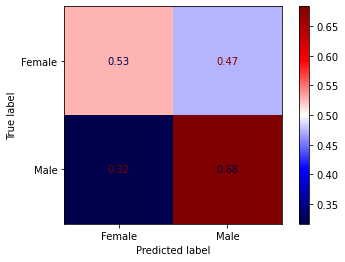

In [19]:
#clf = svm.LinearSVC(class_weight={'Female':10, 'Male': 1},dual=False)
best_found_weights = genetic_weight_search(30,20,svm.LinearSVC,["Female","Male"],x_train,y_train["OffSex"],x_val,y_val["OffSex"])
clf = svm.LinearSVC(class_weight=best_found_weights,dual=False)
clf.fit(x_train, y_train["OffSex"])
print("done fitting")
print("Accuracy on female class: "+str(clf.score(x_test[y_test["OffSex"]=="Female"],y_test["OffSex"][y_test["OffSex"]=="Female"])))
print("Accuracy on male class: "+str(clf.score(x_test[y_test["OffSex"]=="Male"],y_test["OffSex"][y_test["OffSex"]=="Male"])))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffSex"],normalize='true',cmap="seismic")


0.9779166666666667


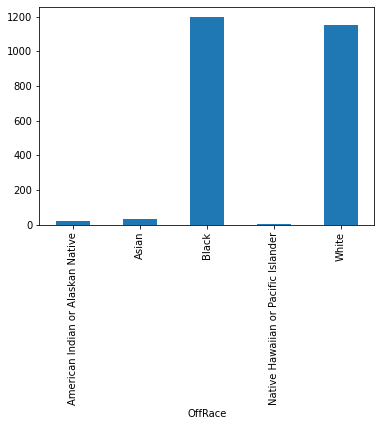

In [20]:
df=y_test.groupby(["OffRace"]).size()
df.plot(kind='bar')
#print(len(y_test[(y_test["OffRace"]=="Black") | (y_test["OffRace"]=="White") ])/len(y_test))

no weighted penalty for the classes
done fitting


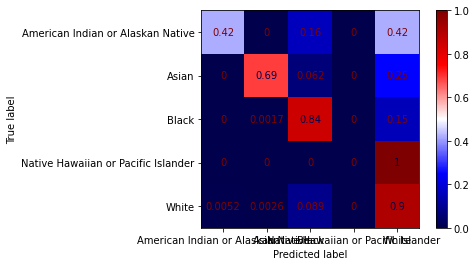

In [21]:
clf = svm.LinearSVC(dual=False)
clf.fit(x_train, y_train["OffRace"])
print("no weighted penalty for the classes")
print("done fitting")
clf.score(x_test,y_test["OffRace"])
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffRace"],normalize='true',cmap="seismic")

In [22]:
best_found_weights = genetic_weight_search(30,20,svm.LinearSVC,["Asian","Black","White","American Indian or Alaskan Native"],x_train,y_train["OffRace"],x_val,y_val["OffRace"])

(0.27745995570347537, {'Asian': 6.563530455128253, 'Black': 1.3979806375835973, 'White': 1.092320144222759, 'American Indian or Alaskan Native': 6.190916661738975})
(0.27758200747837714, {'Asian': 6.496802324676597, 'Black': 1.2270568120520238, 'White': 1.0735417720723441, 'American Indian or Alaskan Native': 6.491648630504674})
(0.2781597015626193, {'Asian': 6.8300835642480955, 'Black': 1.5432105365357027, 'White': 1.357941743230247, 'American Indian or Alaskan Native': 6.2249990825317})
(0.2781597015626193, {'Asian': 6.8300835642480955, 'Black': 1.5432105365357027, 'White': 1.357941743230247, 'American Indian or Alaskan Native': 6.2249990825317})
(0.2995725955635521, {'Asian': 7.347837435169548, 'Black': 1.5504785493235271, 'White': 0.937486740250908, 'American Indian or Alaskan Native': 6.272246879417105})
(0.2995725955635521, {'Asian': 7.347837435169548, 'Black': 1.5504785493235271, 'White': 0.937486740250908, 'American Indian or Alaskan Native': 6.272246879417105})
(0.300162578664

done fitting


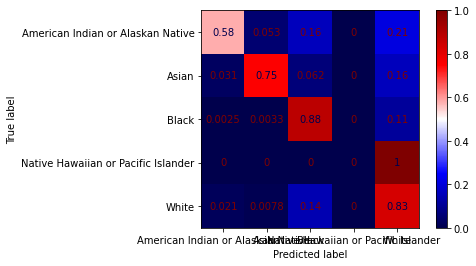

In [24]:
clf = svm.LinearSVC(class_weight=best_found_weights,dual=False)
clf.fit(x_train, y_train["OffRace"])
print("done fitting")
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test["OffRace"],normalize='true',cmap="seismic")